# **Install and Import Libraries**

In [ ]:

!pip install pyngrok
!pip install xgboost


import pandas as pd
import os
import numpy as np
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from flask import Flask, request, render_template_string
import pickle
from pyngrok import ngrok

# Set configurations
plt.rcParams['figure.figsize'] = (14, 8)
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


# **Data Loading and Preprocessing**

In [ ]:
# Load dataset
data = pd.read_csv('creditcard.csv')

# Drop unnecessary columns
data.drop(['Time', 'Amount'], axis=1, inplace=True)

# Separate features and target
X = data.drop('Class', axis=1)
Y = data['Class']


# **Isolation Forest**

In [ ]:
# Apply Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.001, random_state=RANDOM_SEED)
outliers = iso_forest.fit_predict(X)

# Filter only "inliers"
X_filtered = X[outliers == 1]
Y_filtered = Y[outliers == 1]


# **Handle Imbalance Using ADASYN**

In [ ]:
adasyn = ADASYN(random_state=RANDOM_SEED)
X_resampled, Y_resampled = adasyn.fit_resample(X_filtered, Y_filtered)


# **Train Test Split**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_resampled, Y_resampled, test_size=0.2, random_state=RANDOM_SEED
)


# **XGBoost Classifier**

In [ ]:
xgb_model = XGBClassifier(
    scale_pos_weight=(len(Y_train) - sum(Y_train)) / sum(Y_train),
    learning_rate=0.1, n_estimators=100, max_depth=6,
    min_child_weight=1, gamma=0.1, subsample=0.8,
    colsample_bytree=0.8, objective='binary:logistic',
    nthread=4, seed=RANDOM_SEED
)

xgb_model.fit(X_train, Y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

# **Model Evaluation**

Accuracy Score: 0.9965512690801918
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56748
           1       0.99      1.00      1.00     56917

    accuracy                           1.00    113665
   macro avg       1.00      1.00      1.00    113665
weighted avg       1.00      1.00      1.00    113665



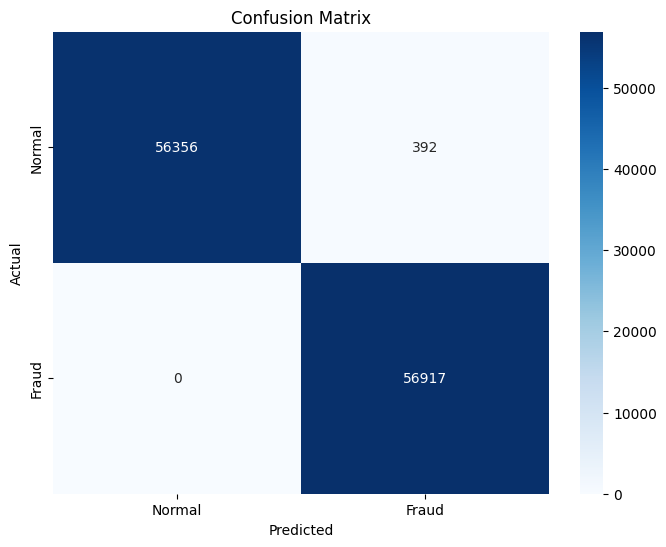

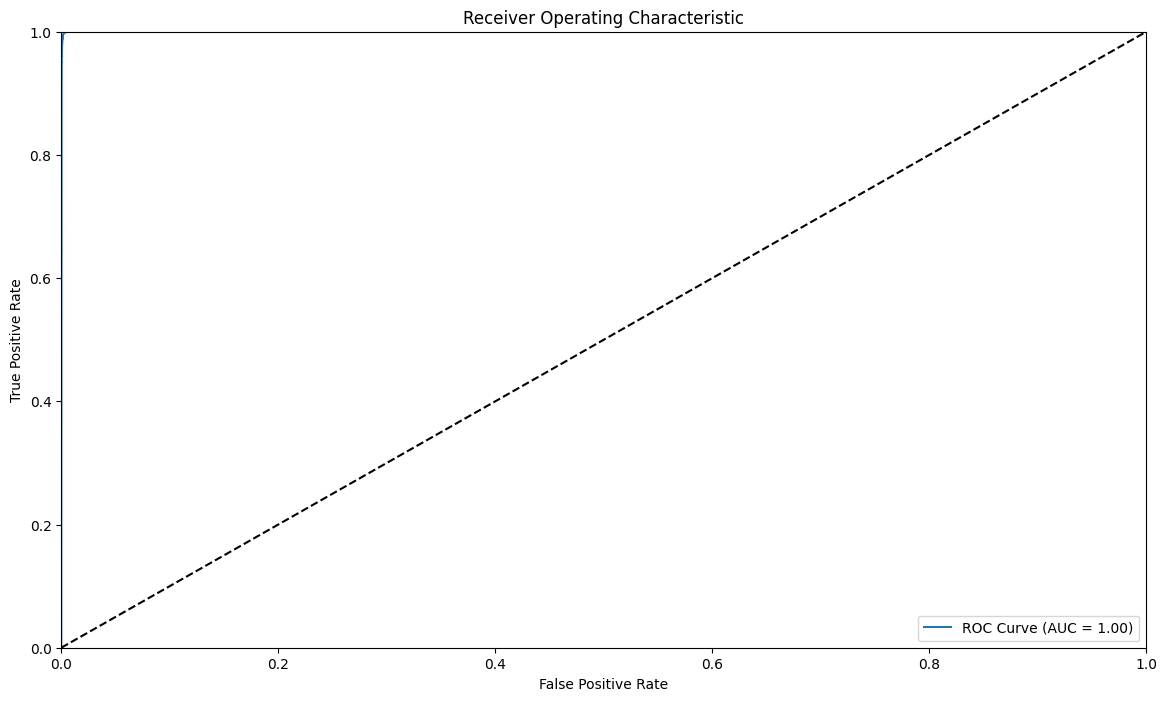

In [ ]:
# Predictions
xgb_pred_test = xgb_model.predict(X_test)

# Metrics
print("Accuracy Score:", accuracy_score(Y_test, xgb_pred_test))
print("Classification Report:")
print(classification_report(Y_test, xgb_pred_test))

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, xgb_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Curve
xgb_prob_test = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(Y_test, xgb_prob_test)
roc_auc = roc_auc_score(Y_test, xgb_prob_test)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# **Save and Load Model**

In [ ]:
# Save model
with open('fraud_detection_model.pkl', 'wb') as model_file:
    pickle.dump(xgb_model, model_file)

# Load model
model = pickle.load(open('fraud_detection_model.pkl', 'rb'))


# **Flask App and Ngrok**

In [ ]:
# Flask app setup
app = Flask(__name__)

# Start Ngrok
os.system("ngrok authtoken 2mpVF6OsdXTbQA3WLuVnGalmCq8_795t7vg8GTKdkR6R43QV2 ")

public_url = ngrok.connect(8000)
print(f"Public URL: {public_url}")

@app.route('/')
def home():
    return render_template_string("""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Fraud Detection</title>
    </head>
    <body>

        <h2 style="display: flex;
        justify-content: center;
        font-size: 40px;">Credit Card Fraud Detection</h2>
        <div id="cnet" ></div>
        <form action="/predict" method="post" style="position: relative; left: 330px; top:50px">
            <label style="font: sans-serif;
            font-size: 30px;">Enter Transaction Data (comma-separated values):</label><br><br>
            <input style="margin-left: 100px;
            width: 300px;
            height: 30px;
            border-radius: 5px;" id="inp" type="text" name="features" placeholder="Enter values separated by commas"><br><br>
            <input style="width: 100px;
            height: 20px;
            border-radius: 5px;
            margin-left: 200px;" id="butt" type="submit" value="Check for Fraud">
        </form>
    </div>

        <!-- <h3 style="display: flex;
        justify-content: center;
        font-size: 50px;
        color: red;" ><br>Transaction is: {output}</h3> -->

    </body>
    </html>
    """)

@app.route('/predict', methods=['POST'])
def predict():
    features = request.form['features']
    features_list = list(map(float, features.split(',')))
    final_features = np.array(features_list).reshape(1, -1)
    prediction = model.predict(final_features)

    if prediction == 1:
      output = 'Fraud'
      return render_template_string(f'''
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Fraud Detection</title>
    </head>
    <body>

        <h2 style="display: flex;
        justify-content: center;
        font-size: 40px;">Credit Card Fraud Detection</h2>
        <div id="cnet" ></div>
        <form action="/predict" method="post" style="position: relative; left: 330px; top:50px">
            <label style="font: sans-serif;
            font-size: 30px;">Enter Transaction Data (comma-separated values):</label><br><br>
            <input style="margin-left: 100px;
            width: 300px;
            height: 30px;
            border-radius: 5px;" id="inp" type="text" name="features" placeholder="Enter values separated by commas"><br><br>
            <input style="width: 100px;
            height: 20px;
            border-radius: 5px;
            margin-left: 200px;" id="butt" type="submit" value="Check for Fraud">
        </form>
    </div>

        <h3 style="display: flex;
        justify-content: center;
        font-size: 50px;
        color: red;" ><br>Transaction is: {output}</h3>

    </body>
    </html>
    ''')

    else :
      output='Not Fraud'
      return render_template_string(f'''
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Fraud Detection</title>
    </head>
    <body>

        <h2 style="display: flex;
        justify-content: center;
        font-size: 40px;">Credit Card Fraud Detection</h2>
        <div id="cnet" ></div>
        <form action="/predict" method="post" style="position: relative; left: 330px; top:50px">
            <label style="font: sans-serif;
            font-size: 30px;">Enter Transaction Data (comma-separated values):</label><br><br>
            <input style="margin-left: 100px;
            width: 300px;
            height: 30px;
            border-radius: 5px;" id="inp" type="text" name="features" placeholder="Enter values separated by commas"><br><br>
            <input style="width: 100px;
            height: 20px;
            border-radius: 5px;
            margin-left: 200px;" id="butt" type="submit" value="Check for Fraud">
        </form>
    </div>

        <h3 style="display: flex;
        justify-content: center;
        font-size: 50px;
        color: green;" ><br>Transaction is: {output}</h3>

    </body>
    </html>
    ''')

if __name__ == '__main__':
    app.run(port=8000)



Public URL: NgrokTunnel: "https://c5e1-35-226-147-219.ngrok-free.app" -> "http://localhost:8000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:8000
INFO:werkzeug:Press CTRL+C to quit


Accuracy Score: 0.9965512690801918
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56748
           1       0.99      1.00      1.00     56917

    accuracy                           1.00    113665
   macro avg       1.00      1.00      1.00    113665
weighted avg       1.00      1.00      1.00    113665



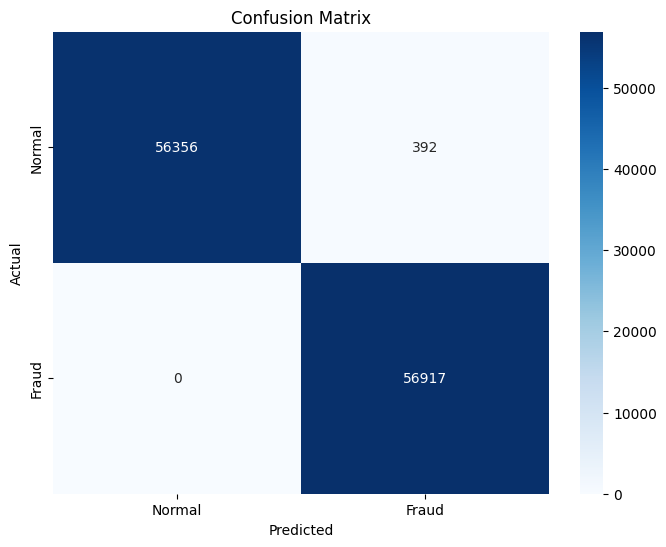

ROC-AUC Score: 0.999819899584347


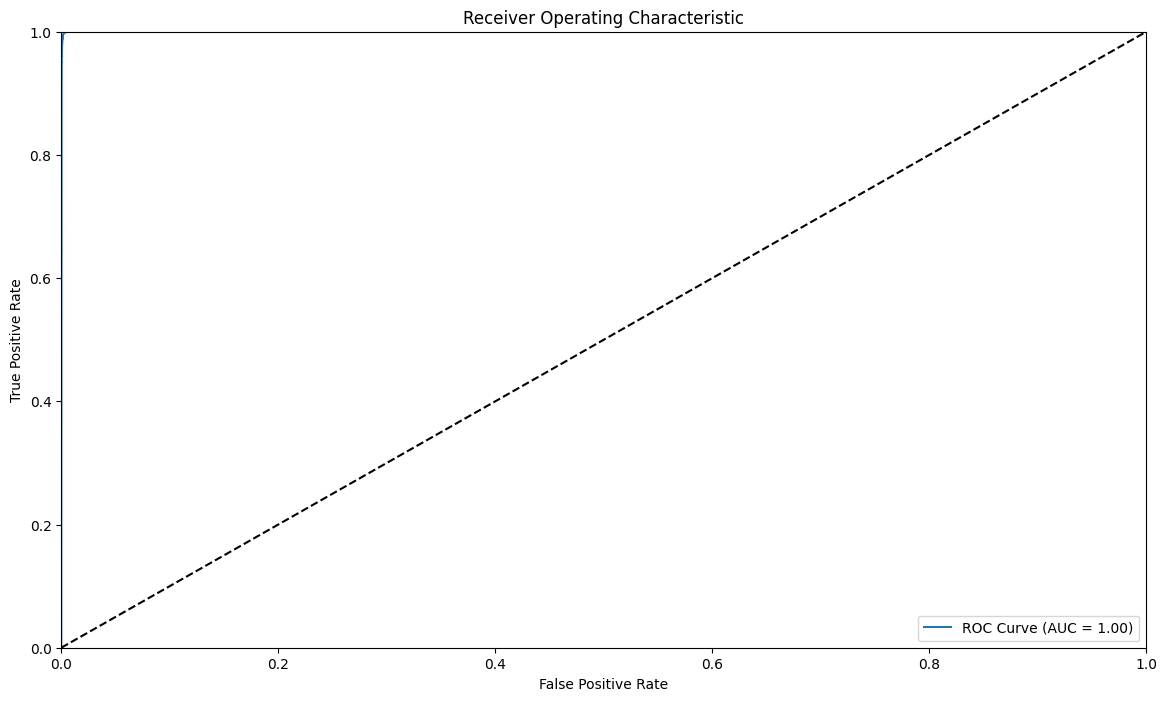

Average Precision Score: 0.9997218096449284


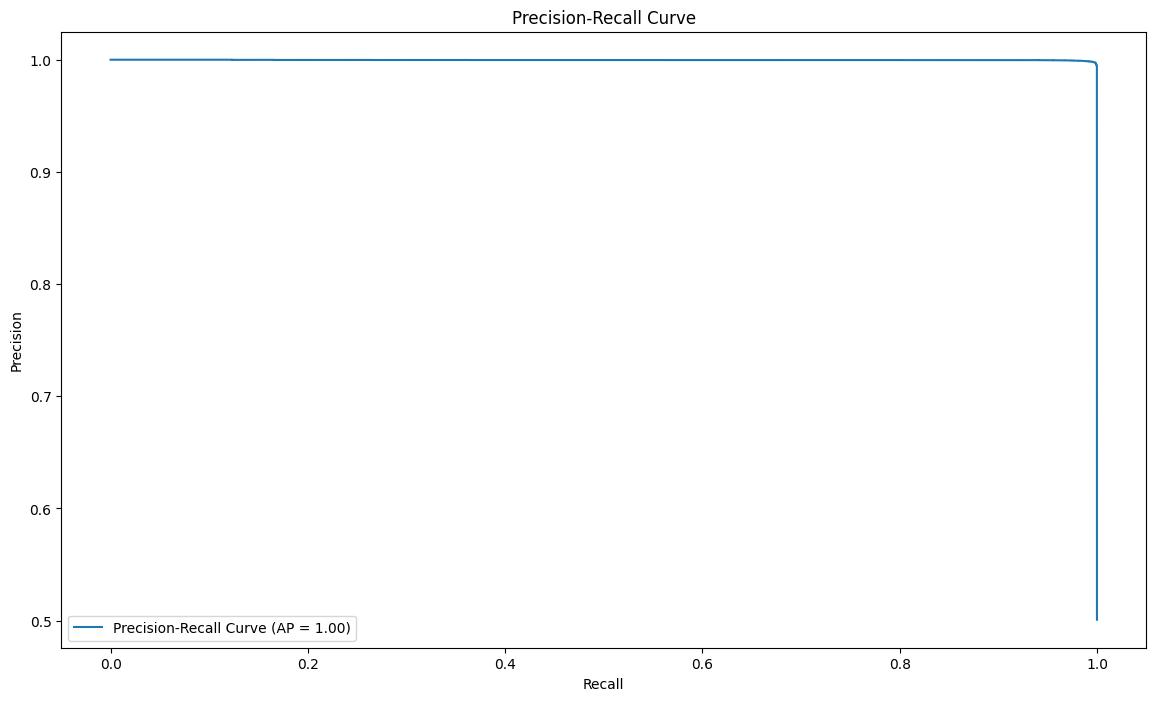

Public URL: NgrokTunnel: "https://d5b6-35-226-147-219.ngrok-free.app" -> "http://localhost:8000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:8000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [19/Nov/2024 05:49:17] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Nov/2024 05:50:11] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Nov/2024 05:50:27] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Nov/2024 06:11:29] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Nov/2024 06:23:01] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Nov/2024 06:23:07] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Nov/2024 06:33:38] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Nov/2024 06:41:44] "POST /predict HTTP/1.1" 200 -


In [ ]:
!pip install pyngrok
!pip install xgboost
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from flask import Flask, request, render_template_string
import pickle
from pyngrok import ngrok


plt.rcParams['figure.figsize'] = (14, 8)


RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


data = pd.read_csv('creditcard.csv')


data.drop(['Time', 'Amount'], axis=1, inplace=True)


X = data.drop('Class', axis=1)
Y = data['Class']


iso_forest = IsolationForest(contamination=0.001, random_state=RANDOM_SEED)
outliers = iso_forest.fit_predict(X)

X_filtered = X[outliers == 1]
Y_filtered = Y[outliers == 1]

adasyn = ADASYN(random_state=RANDOM_SEED)
X_resampled, Y_resampled = adasyn.fit_resample(X_filtered, Y_filtered)

X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=RANDOM_SEED)

xgb_model = XGBClassifier(
    scale_pos_weight=(len(Y_train) - sum(Y_train)) / sum(Y_train),
    learning_rate=0.1,
    n_estimators=100,
    max_depth=6,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    seed=RANDOM_SEED
)

xgb_model.fit(X_train, Y_train)

xgb_pred_test = xgb_model.predict(X_test)

print("Accuracy Score:", accuracy_score(Y_test, xgb_pred_test))
print("Classification Report:")
print(classification_report(Y_test, xgb_pred_test))

conf_matrix = confusion_matrix(Y_test, xgb_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

xgb_prob_test = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(Y_test, xgb_prob_test)
roc_auc = roc_auc_score(Y_test, xgb_prob_test)
print("ROC-AUC Score:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

precision, recall, _ = precision_recall_curve(Y_test, xgb_prob_test)
average_precision = average_precision_score(Y_test, xgb_prob_test)
print("Average Precision Score:", average_precision)

plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

with open('fraud_detection_model.pkl', 'wb') as model_file:
    pickle.dump(xgb_model, model_file)

app = Flask(__name__)

os.system("ngrok authtoken 2mpVF6OsdXTbQA3WLuVnGalmCq8_795t7vg8GTKdkR6R43QV2 ")

public_url = ngrok.connect(8000)
print(f"Public URL: {public_url}")

model = pickle.load(open('fraud_detection_model.pkl', 'rb'))

@app.route('/')
def home():
    return render_template_string('''

    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Fraud Detection</title>
    </head>
    <body>

        <h2 style="display: flex;
        justify-content: center;
        font-size: 40px;">Credit Card Fraud Detection</h2>
        <div id="cnet" ></div>
        <form action="/predict" method="post" style="position: relative; left: 330px; top:50px">
            <label style="font: sans-serif;
            font-size: 30px;">Enter Transaction Data (comma-separated values):</label><br><br>
            <input style="margin-left: 100px;
            width: 300px;
            height: 30px;
            border-radius: 5px;" id="inp" type="text" name="features" placeholder="Enter values separated by commas"><br><br>
            <input style="width: 100px;
            height: 20px;
            border-radius: 5px;
            margin-left: 200px;" id="butt" type="submit" value="Check for Fraud">
        </form>
    </div>

        <!-- <h3 style="display: flex;
        justify-content: center;
        font-size: 50px;
        color: red;" ><br>Transaction is: {output}</h3> -->

    </body>
    </html>
    ''')

@app.route('/predict', methods=['POST'])
def predict():
    features = request.form['features']

    features_list = list(map(float, features.split(',')))

    final_features = np.array(features_list).reshape(1, -1)

    prediction = model.predict(final_features)

    if prediction == 1:
      output = 'Fraud'
      return render_template_string(f'''
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Fraud Detection</title>
    </head>
    <body>

        <h2 style="display: flex;
        justify-content: center;
        font-size: 40px;">Credit Card Fraud Detection</h2>
        <div id="cnet" ></div>
        <form action="/predict" method="post" style="position: relative; left: 330px; top:50px">
            <label style="font: sans-serif;
            font-size: 30px;">Enter Transaction Data (comma-separated values):</label><br><br>
            <input style="margin-left: 100px;
            width: 300px;
            height: 30px;
            border-radius: 5px;" id="inp" type="text" name="features" placeholder="Enter values separated by commas"><br><br>
            <input style="width: 100px;
            height: 20px;
            border-radius: 5px;
            margin-left: 200px;" id="butt" type="submit" value="Check for Fraud">
        </form>
    </div>

        <h3 style="display: flex;
        justify-content: center;
        font-size: 50px;
        color: red;" ><br>Transaction is: {output}</h3>

    </body>
    </html>
    ''')

    else :
      output='Not Fraud'
      return render_template_string(f'''
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Fraud Detection</title>
    </head>
    <body>

        <h2 style="display: flex;
        justify-content: center;
        font-size: 40px;">Credit Card Fraud Detection</h2>
        <div id="cnet" ></div>
        <form action="/predict" method="post" style="position: relative; left: 330px; top:50px">
            <label style="font: sans-serif;
            font-size: 30px;">Enter Transaction Data (comma-separated values):</label><br><br>
            <input style="margin-left: 100px;
            width: 300px;
            height: 30px;
            border-radius: 5px;" id="inp" type="text" name="features" placeholder="Enter values separated by commas"><br><br>
            <input style="width: 100px;
            height: 20px;
            border-radius: 5px;
            margin-left: 200px;" id="butt" type="submit" value="Check for Fraud">
        </form>
    </div>

        <h3 style="display: flex;
        justify-content: center;
        font-size: 50px;
        color: green;" ><br>Transaction is: {output}</h3>

    </body>
    </html>
    ''')

if __name__ == '__main__':
    app.run(port=8000)